<a href="https://colab.research.google.com/github/eneskosar/1D-CNN-IMPLEMENTATION/blob/master/Phase3_Final_WeightedLoss_10k_lr001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

import numpy as np 
mitbit_test = np.genfromtxt('/content/gdrive/My Drive/Colab Notebooks/DataProject/mitbih_test.csv', delimiter=',')
mitbit_train = np.genfromtxt('/content/gdrive/My Drive/Colab Notebooks/DataProject/mitbih_train.csv', delimiter=',')


In [ ]:
mitbit_test_data = mitbit_test[:,:-1]
mitbit_test_labels = np.reshape(mitbit_test[:,-1],(len(mitbit_test[:,-1]),1)).astype(int)
mitbit_train_data = mitbit_train[:,:-1]
mitbit_train_labels = np.reshape(mitbit_train[:,-1],(len(mitbit_train[:,-1]),1)).astype(int)

In [ ]:
  # Shuffle the training data
permutation = np.random.permutation(len(mitbit_train_data[63000:87000,:])) #np.random.permutation(len(mitbit_train_data[70000:87000,:]))
train_images = mitbit_train_data[63000:87000,:][permutation] #mitbit_train_data[70000:87000,:][permutation]
train_labels = mitbit_train_labels[63000:87000,:][permutation] #mitbit_train_labels[70000:87000,:][permutation]

numLabel0 = np.count_nonzero(train_labels == 0)
numLabel1 = np.count_nonzero(train_labels == 1)
numLabel2 = np.count_nonzero(train_labels == 2)
numLabel3 = np.count_nonzero(train_labels == 3)
numLabel4 = np.count_nonzero(train_labels == 4)
penaltyWeightsBasedOnLabels = np.array([(10000/numLabel0), (10000/numLabel1), (10000/numLabel2), (10000/numLabel3), (10000/numLabel4)])



In [ ]:
print(penaltyWeightsBasedOnLabels)

[ 1.05585471  4.49842555  1.72771251 15.60062402  1.70154841]


In [ ]:
permutation2 = np.random.permutation(len(mitbit_test_labels)) 
validation_images = mitbit_test_data[permutation2][0:5000] 
validation_labels = mitbit_test_labels[permutation2][0:5000]

mitbit_test_data2 = mitbit_test_data[permutation2][5000:len(mitbit_test_data)]
mitbit_test_labels2 = mitbit_test_labels[permutation2][5000:len(mitbit_test_data)] 

# Main

In [ ]:
def forward(image, label, penaltyWeight = penaltyWeightsBasedOnLabels):
  # inputImage = np.random.randn(4, 4)
  #inputImage = (mitbit_test_data[1]/ 255) - 0.5
  #arr = np.array([1,2,3,4,5,4,3,2,1])
  #image = (image/ 255) - 0.5
  res = conv.forward(image)
  res = pooling.forward(res)
  res = conv2.forward(res)
  res = pooling2.forward(res)
  probs = softmax.forward(res)
  y_prediction = np.argmax(probs)
  if probs[label] > 0.01:   
    loss = -penaltyWeight[label]*np.log(probs[label])
  else:
    loss = -penaltyWeight[label]*(-2)
  #if loss < 2000 and loss >0:
  #  a = 1
  #else: 
  #  print(probs, label, penaltyWeight, res)

  correctness = 1 if np.argmax(probs) == label else 0

  return probs, loss, correctness, y_prediction

def train(im, label, lr=.01, penaltyWeight = penaltyWeightsBasedOnLabels):
  # Forward
  out, loss, acc, y_prediction = forward(im, label)

  # Calculate initial gradient
  gradient = np.zeros(5)
  if out[label] > 0.01:
    gradient[label] = -penaltyWeight[label] / out[label]
  else:
    gradient[label] = -penaltyWeight[label] / 0.01
  # Backprop
  gradient = softmax.backprop(gradient, lr)
  gradient = pooling2.backprop(gradient)
  gradient = conv2.backprop(gradient, lr)
  gradient = pooling.backprop(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc


In [ ]:
conv = Convolution1by3()
pooling = MaxPooling()
conv2 = Convolution1by3()
pooling2 = MaxPooling()
softmax = Softmax(46, 5)

numEpochs = 15
import time

start_time = time.time()

training_accuracy_arr = np.zeros(numEpochs)
training_accuracy_arr_seperately = np.zeros((numEpochs,5))
validation_accuracy_arr = np.zeros(numEpochs)
validation_accuracy_arr_seperately = np.zeros((numEpochs,5))
f1ScoreArrVal = np.zeros(numEpochs)
f1ScoreArrTrain = np.zeros(numEpochs)
LossValArr = np.zeros(numEpochs)
LossTrainArr = np.zeros(numEpochs)
for epoch in range(numEpochs):
  print('--- Epoch %d ---' % (epoch + 1))

  train_data = train_images
  train_labels = train_labels

  # Train!
  loss = 0
  num_correct = 0
  validation_num_correct = 0
  for i, (im, label) in enumerate(zip(train_data, train_labels)):
    if i > 0 and i % 500 == 499:
      print(
        '[Step %d] Past 500 steps: Average Loss %.3f | Accuracy: %d%% | Validation accuracy: %d%%' %
        (i + 1, loss / 500, num_correct/5, validation_num_correct/5)
      )
      loss = 0
      num_correct = 0
      validation_num_correct = 0
    l, acc = train(im, label)
    loss += l
    #print(epoch, loss)
    p,l,a, y_prediction = forward(validation_images[0:500,:][(i%500)], validation_labels[0:500][(i%500)])
    num_correct += acc
    validation_num_correct += a


  validation_num_correct = np.zeros(5)
  confusionMatrix = np.zeros((5,5))
   
  for i in range(len(validation_labels)):
    im = validation_images[i,:]
    label = validation_labels[i]
    p,l,a, y_prediction = forward(im, label)
    LossValArr[epoch] += l
    validation_num_correct[label] += a
    confusionMatrix[label,y_prediction] +=1  
  validation_accuracy_arr[epoch] = (validation_num_correct[0] + validation_num_correct[1]+validation_num_correct[2] + validation_num_correct[3]+validation_num_correct[4])/len(validation_labels) 
  validation_accuracy_arr_seperately[epoch, 0] = validation_num_correct[0] /np.count_nonzero(validation_labels == 0)
  validation_accuracy_arr_seperately[epoch, 1] = validation_num_correct[1] /np.count_nonzero(validation_labels == 1)
  validation_accuracy_arr_seperately[epoch, 2] = validation_num_correct[2] /np.count_nonzero(validation_labels == 2)
  validation_accuracy_arr_seperately[epoch, 3] = validation_num_correct[3] /np.count_nonzero(validation_labels == 3)
  validation_accuracy_arr_seperately[epoch, 4] = validation_num_correct[4] /np.count_nonzero(validation_labels == 4)
  precision = np.zeros(5)
  recall = np.zeros(5)
  for i in range(5):
    precision[i] = confusionMatrix[i,i] / (confusionMatrix[0,i] + confusionMatrix[1,i] + confusionMatrix[2,i] + confusionMatrix[3,i] + confusionMatrix[4,i]) 
  for i in range(5):
    recall[i] = confusionMatrix[i,i] / (confusionMatrix[i,0] + confusionMatrix[i,1] + confusionMatrix[i,2] + confusionMatrix[i,3] + confusionMatrix[i,4]) 
  avg_precision = np.mean(precision)
  avg_recall = np.mean(recall)
  f1_score = 2*avg_precision*avg_recall/(avg_precision + avg_recall)
  f1ScoreArrVal[epoch] = f1_score
  print(validation_accuracy_arr_seperately[epoch,:])
  print(f1ScoreArrVal[epoch])
  print(LossValArr[epoch])

  training_num_correct = np.zeros(5)
  confusionMatrix = np.zeros((5,5))
  for i in range(len(train_labels)):
    im = train_images[i,:]
    label = train_labels[i]
    p,l,a, y_prediction = forward(im, label)
    LossTrainArr[epoch] += l
    training_num_correct[label] += a  
    confusionMatrix[label,y_prediction] +=1
  training_accuracy_arr[epoch] = (training_num_correct[0] + training_num_correct[1]+training_num_correct[2] + training_num_correct[3]+training_num_correct[4])/len(train_labels)
  training_accuracy_arr_seperately[epoch, 0] = training_num_correct[0] /numLabel0
  training_accuracy_arr_seperately[epoch, 1] = training_num_correct[1] /numLabel1
  training_accuracy_arr_seperately[epoch, 2] = training_num_correct[2] /numLabel2
  training_accuracy_arr_seperately[epoch, 3] = training_num_correct[3] /numLabel3
  training_accuracy_arr_seperately[epoch, 4] = training_num_correct[4] /numLabel4
  precision = np.zeros(5)
  recall = np.zeros(5)
  for i in range(5):
    precision[i] = confusionMatrix[i,i] / (confusionMatrix[0,i] + confusionMatrix[1,i] + confusionMatrix[2,i] + confusionMatrix[3,i] + confusionMatrix[4,i]) 
  for i in range(5):
    recall[i] = confusionMatrix[i,i] / (confusionMatrix[i,0] + confusionMatrix[i,1] + confusionMatrix[i,2] + confusionMatrix[i,3] + confusionMatrix[i,4]) 
  avg_precision = np.mean(precision)
  avg_recall = np.mean(recall)
  f1_score = 2*avg_precision*avg_recall/(avg_precision + avg_recall)
  f1ScoreArrTrain[epoch] = f1_score 
  print(training_accuracy_arr_seperately[epoch, :])
  print(f1ScoreArrTrain[epoch])
  print(LossTrainArr[epoch])


end_time = time.time()



--- Epoch 1 ---
[Step 500] Past 500 steps: Average Loss 3.154 | Accuracy: 29% | Validation accuracy: 25%
[Step 1000] Past 500 steps: Average Loss 3.530 | Accuracy: 31% | Validation accuracy: 23%
[Step 1500] Past 500 steps: Average Loss 2.642 | Accuracy: 37% | Validation accuracy: 25%
[Step 2000] Past 500 steps: Average Loss 3.092 | Accuracy: 40% | Validation accuracy: 40%
[Step 2500] Past 500 steps: Average Loss 3.058 | Accuracy: 37% | Validation accuracy: 22%
[Step 3000] Past 500 steps: Average Loss 2.536 | Accuracy: 46% | Validation accuracy: 29%
[Step 3500] Past 500 steps: Average Loss 2.523 | Accuracy: 46% | Validation accuracy: 38%
[Step 4000] Past 500 steps: Average Loss 2.729 | Accuracy: 41% | Validation accuracy: 32%
[Step 4500] Past 500 steps: Average Loss 2.370 | Accuracy: 48% | Validation accuracy: 36%
[Step 5000] Past 500 steps: Average Loss 2.382 | Accuracy: 49% | Validation accuracy: 37%
[Step 5500] Past 500 steps: Average Loss 1.838 | Accuracy: 59% | Validation accuracy:

In [ ]:
print(training_accuracy_arr)
print(validation_accuracy_arr)
#print(training_accuracy_arr_seperately)
#print(validation_accuracy_arr_seperately)
print(training_num_correct)
print(validation_num_correct)
print(f1ScoreArrVal)
print(f1ScoreArrTrain)

[0.522625   0.63166667 0.64141667 0.64733333 0.65216667 0.65083333
 0.65245833 0.6545     0.65379167 0.65166667 0.6475     0.65066667
 0.637375   0.619625   0.621875  ]
[0.4198 0.5348 0.5472 0.5676 0.5698 0.5708 0.5888 0.5666 0.5544 0.558
 0.559  0.5628 0.5528 0.4868 0.4924]
[4261. 1766. 3063.  536. 5299.]
[1814.   95.  164.   34.  355.]
[0.44546026 0.51265514 0.51502411 0.51841052 0.51639745 0.51848742
 0.53192398 0.52356192 0.52006595 0.52523909 0.52506231 0.5323582
 0.53228972 0.508751   0.5110349 ]
[0.57610609 0.64082845 0.64592177 0.64800109 0.65078135 0.6500766
 0.65135433 0.65410472 0.65541331 0.65442938 0.65341445 0.65895459
 0.6480189  0.63889888 0.64034443]


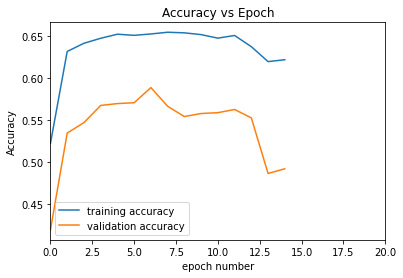

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(numEpochs), training_accuracy_arr, label = "training accuracy") 
plt.plot(range(numEpochs), validation_accuracy_arr, label = "validation accuracy")  
#plt.ylim([0,6.0])
plt.xlim([0,20.0])
plt.xlabel('epoch number') 
plt.ylabel('Accuracy') 
plt.title('Accuracy vs Epoch') 
plt.legend()   
plt.show()

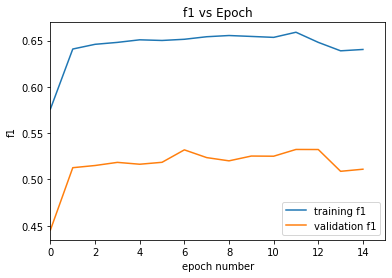

In [ ]:
plt.plot(range(numEpochs), f1ScoreArrTrain, label = "training f1") 
plt.plot(range(numEpochs), f1ScoreArrVal, label = "validation f1")  
#plt.ylim([0,6.0])
plt.xlim([0,15.0])
plt.xlabel('epoch number') 
plt.ylabel('f1') 
plt.title('f1 vs Epoch') 
plt.legend()   
plt.show()

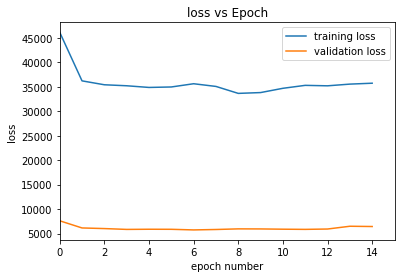

In [ ]:
plt.plot(range(numEpochs), LossTrainArr, label = "training loss") 
plt.plot(range(numEpochs), LossValArr, label = "validation loss")  
#plt.ylim([0,6.0])
plt.xlim([0,15.0])
plt.xlabel('epoch number') 
plt.ylabel('loss') 
plt.title('loss vs Epoch') 
plt.legend()   
plt.show()

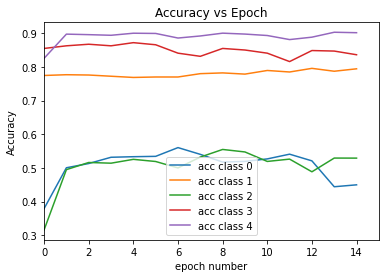

In [ ]:
plt.plot(range(numEpochs), training_accuracy_arr_seperately[:,0], label = "acc class 0") 
plt.plot(range(numEpochs), training_accuracy_arr_seperately[:,1], label = "acc class 1") 
plt.plot(range(numEpochs), training_accuracy_arr_seperately[:,2], label = "acc class 2") 
plt.plot(range(numEpochs), training_accuracy_arr_seperately[:,3], label = "acc class 3") 
plt.plot(range(numEpochs), training_accuracy_arr_seperately[:,4], label = "acc class 4") 

#plt.ylim([0,6.0])
plt.xlim([0,15.0])
plt.xlabel('epoch number') 
plt.ylabel('Accuracy') 
plt.title('Accuracy vs Epoch') 
plt.legend()   
plt.show()

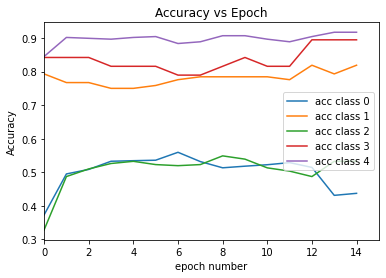

In [ ]:
plt.plot(range(numEpochs), validation_accuracy_arr_seperately[:,0], label = "acc class 0") 
plt.plot(range(numEpochs), validation_accuracy_arr_seperately[:,1], label = "acc class 1") 
plt.plot(range(numEpochs), validation_accuracy_arr_seperately[:,2], label = "acc class 2") 
plt.plot(range(numEpochs), validation_accuracy_arr_seperately[:,3], label = "acc class 3") 
plt.plot(range(numEpochs), validation_accuracy_arr_seperately[:,4], label = "acc class 4") 

#plt.ylim([0,6.0])
plt.xlim([0,15.0])
plt.xlabel('epoch number') 
plt.ylabel('Accuracy') 
plt.title('Accuracy vs Epoch') 
plt.legend()   
plt.show()

In [ ]:
print(end_time-start_time)

2014.4153594970703


In [ ]:

# TESTING 
import collections

mitbit_test_data2 = mitbit_test_data[permutation2][5000:len(mitbit_test_data)]
mitbit_test_labels2 = mitbit_test_labels[permutation2][5000:len(mitbit_test_data)]

totalLoss = 0
totalCorrect = np.zeros(5)
num_tests = len(mitbit_test_labels2)
numLabels = np.zeros(5)
confusionMatrix = np.zeros((5,5))

for i in range(len(mitbit_test_data2)):
  im = mitbit_test_data2[i]
  label = mitbit_test_labels2[i]
  prob, loss, correctness, y_prediction = forward(im, label)
  totalLoss += loss
  totalCorrect[label] += correctness
  confusionMatrix[label,y_prediction] +=1


for i in range(5):
   numLabels[i] = np.count_nonzero(mitbit_test_labels2 == i)

for i in range(5):
  totalCorrect[i] = totalCorrect[i]/numLabels[i]

# print('Test Loss:', totalLoss / num_tests)

print('Test Accuracy: ')
print(totalCorrect )
print('Distribution of data in test set: ')
print(numLabels )



Test Accuracy: 
[0.43688695 0.74318182 0.50964912 0.87903226 0.8984439 ]
Distribution of data in test set: 
[13967.   440.  1140.   124.  1221.]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(69.0, 0.5, 'true label')

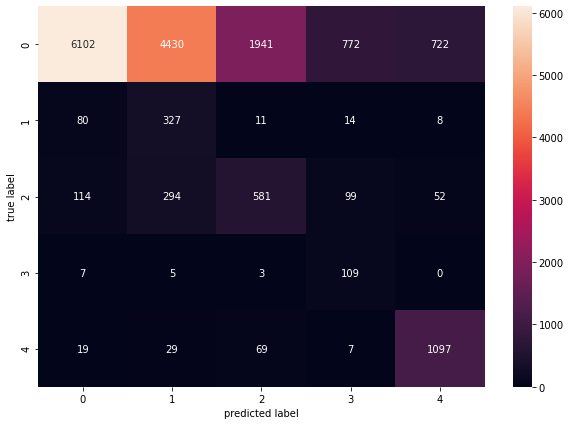

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusionMatrix.astype(int), index = [i for i in range(5)],
                  columns = [i for i in range(5)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d')
plt.xlabel('predicted label')
plt.ylabel('true label')

In [ ]:
precision = np.zeros(5)
recall = np.zeros(5)

for i in range(5):
  precision[i] = confusionMatrix[i,i] / (confusionMatrix[0,i] + confusionMatrix[1,i] + confusionMatrix[2,i] + confusionMatrix[3,i] + confusionMatrix[4,i]) 


for i in range(5):
  recall[i] = confusionMatrix[i,i] / (confusionMatrix[i,0] + confusionMatrix[i,1] + confusionMatrix[i,2] + confusionMatrix[i,3] + confusionMatrix[i,4]) 

avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
f1_score = 2*avg_precision*avg_recall/(avg_precision + avg_recall)

In [ ]:
print(precision)
print(recall)
print(avg_precision)
print(avg_recall)
print(f1_score)

[0.96520089 0.06430678 0.22303263 0.10889111 0.58382118]
[0.43688695 0.74318182 0.50964912 0.87903226 0.8984439 ]
0.38905051807711233
0.6934388090605583
0.4984487535468793


# Convolution Layer

In [ ]:
import numpy as np

class Convolution1by3:

    def __init__(self):
      #self.filters = np.random.randn(1, 3) 
      self.filters = np.array([1.0,0.0,1.0])
      self.lastWeights = np.array([1.0,0.0,1.0])

    def forward(self, input):
      self.lastInput = input
      l = len(input)
      output = np.zeros(l)
      paddedInput = np.zeros(l+2)
      #print(paddedInput)
      paddedInput[1:(l+1),] = input
      self.lastpaddedInput = paddedInput
      #print(paddedInput)

      for i in range(l):
          output[i] = np.multiply(paddedInput[i:(i+3)] , self.filters).sum()
      
      #ReLu
      #output = np.maximum(0,output)
      return output

    def backprop(self, dLossvsdout, learningRate):

      self.lastWeights = self.filters  
      dLossvsdfilters = np.zeros(3)
      for i in range(len(self.lastInput)):
        a = dLossvsdout[i]
        b = self.lastpaddedInput[i:(i+3)]
        dLossvsdfilters += a*b

      dLossvsdinputs = np.zeros(len(self.lastInput))
      dLossvsdinputs[0] = self.lastWeights[0]* dLossvsdout[0]
      dLossvsdinputs[1] = self.lastWeights[0]* dLossvsdout[0] + self.lastWeights[1]* dLossvsdout[1] 
      for i in range(len(self.lastInput)-2):
          dLossvsdinputs[i+2] =  self.lastWeights[0]* dLossvsdout[i] + self.lastWeights[1]* dLossvsdout[i+1] + self.lastWeights[2]* dLossvsdout[i+2]
      # Update filters
      self.filters -= learningRate * dLossvsdfilters

      return dLossvsdinputs
        




# Pooling Layer

In [ ]:
class MaxPooling:

  #def __init__(self):

  def forward(self, input):
      self.last_input = input

      l = len(input)
      l = l // 2
      output = np.zeros(l)

      for i in range(l):
          output[i] = np.amax(input[2*i:(2*i+2)])
      
      return output

  def backprop(self, dLossvsdout):
      dLossvsdinput = np.zeros(len(self.last_input))
      for i in range(len(dLossvsdout)):
        #print(self.last_input[2*i+1])
        #print(self.last_input[2*i])
        #print(self.last_input[2*i+1] < self.last_input[2*i])
        #print("****************************")
        if  self.last_input[2*i+1] < self.last_input[2*i]:
          dLossvsdinput[2*i] = dLossvsdout[i]
        else:
          dLossvsdinput[2*i+1] = dLossvsdout[i]
      return dLossvsdinput
      

# Softmax Layer

In [ ]:
class Softmax:

    def __init__(self, inputLen, numOfClasses):
      
      self.weights = np.random.randn(inputLen,numOfClasses) 
      self.biases = np.random.randn(numOfClasses)
    
    def forward(self, input):
      input_len, numOfClasses = self.weights.shape
      weightedSums = np.dot(input, self.weights) + self.biases
      ###########################3
      #weightedSums = weightedSums/np.sum(weightedSums, axis=0)
      self.lastInput = input
      self.lastWeightedSums = weightedSums
      
      expedWeightedSums = np.exp(weightedSums-np.amax(weightedSums))
      probs = (expedWeightedSums / np.sum(expedWeightedSums, axis=0))
      return probs

    def backprop(self, dLossvsdout, learningRate):

      for i, gradient in enumerate(dLossvsdout):
        if gradient == 0:
          continue

      # e^weightedSums
        #expWeightedSums = np.exp(self.lastWeightedSums)
        expWeightedSums = np.exp(self.lastWeightedSums-np.amax(self.lastWeightedSums))

      # Sum of all e^weightedSums
        SumExpWeightedSums = np.sum(expWeightedSums)

      # Gradients of out[i] against totals
        dOutvsdt = -expWeightedSums[i] * expWeightedSums / (SumExpWeightedSums ** 2)
        dOutvsdt[i] = expWeightedSums[i] * (SumExpWeightedSums - expWeightedSums[i]) / (SumExpWeightedSums ** 2)

      # Gradients of totals against weights/biases/input
        dWeightedSumsvsdweights = self.lastInput
        dWeightedSumsvsdbiases = 1
        dWeightedSumsvsdinputs = self.weights

      # Gradients of loss against totals
        dLossvsdWeightedSums = gradient * dOutvsdt

      # Gradients of loss against weights/biases/input
        dLossvsdweights = dWeightedSumsvsdweights[np.newaxis].T @ dLossvsdWeightedSums[np.newaxis]
        dLossvsdbiases = dLossvsdWeightedSums * dWeightedSumsvsdbiases
        dLossvsdinputs = dWeightedSumsvsdinputs @ dLossvsdWeightedSums

      # Update weights / biases
        self.weights -= learningRate * dLossvsdweights
        self.biases -= learningRate * dLossvsdbiases
        #print(dLossvsdinputs)
        return dLossvsdinputs

    
